In [1]:
import numpy as np
from matplotlib import pyplot as plt

# mass in GeV/c^2
proton_mass = 0.938272
masses_dict = {'211': 0.139570, '2212': 0.938272, '3112': 1.197449, '321': 0.493677, '3222': 1.18937,
              '3312': 1.32171, '3334': 1.67245, '-211': 0.139570, '-2212': 0.938272, '-3112': 1.197449, 
              '-321': 0.493677, '-3222': 1.18937, '-3312': 1.32171, '-3334': 1.67245}

def get_particle_mass(p_index: str) -> float:
    if len(p_index) != 10:
        return masses_dict[p_index]
    else:
        m = (int(p_index) % 10000) // 10
        return float(m * proton_mass)
        
        
def calc_velocity(p: float, pz: float, ptype: str) -> float:
    return abs(pz) / np.sqrt(get_particle_mass(ptype) **2 + p**2 / 1**2)




def calc_time(v: float, distance: float) -> float:
    c = 2.99722458 * 10**8
    velocity = v * c
    time = distance / velocity
    return time

In [2]:
detector_in_radius = 0.015
detector_out_radius = 0.025

detector_distances = [1, 1.7, 2.5]
# detector_distances = [1]
n_rings = len(detector_distances)

events = []
particles_set = set()
particles_hit_set = set()
lim = 0
for i in range(1, 12):        # iterate over all 11 given files of simulated events (from 1 to 11)
    filename = "data/data_" + str(i) + ".dat"
    with open(filename,'r') as inpf: 
        l = inpf.readline()
        l = inpf.readline()
        l = inpf.readline()
        l = inpf.readline()
        l = inpf.readline()
        
        for l in inpf.readlines():
            s=l.strip().split()
            if len(s) == 5:
                n,npart,b,bx,by = int(s[0]),int(s[1]),float(s[2]),float(s[3]),float(s[4])
                # 
                hits = []
                for j in range(n_rings):
                    hits.append([[],[]])     # for every detector, negative and positive Pz side
                phi_b = np.arctan2(bx,by)
                events.append([b,phi_b,hits])
            elif len(s) == 11:
                p_charge = int(s[0].strip())
                ptype = s[4].strip()
                # if len(ptype) > 5:
                    # ptype = '1000'
                px = float(s[5])
                py = float(s[6])
                pz = float(s[7])
                p_along = abs(pz)
                p_across = np.sqrt(px**2+py**2)
                p_full = np.sqrt(p_across **2 + p_along **2)
                
                if p_charge != 0:
                    particles_set.add(ptype)
                    for ind in range(n_rings):    # for every detector check if particle hit it
                        under_upper_bound = (p_across / p_along) < (detector_out_radius / detector_distances[ind])
                        above_lower_bound = (p_across / p_along) > (detector_in_radius / detector_distances[ind])
                        hit_detector =  under_upper_bound and above_lower_bound
                        if hit_detector:
                            particles_hit_set.add(ptype)
                            pnorm=np.sqrt(px**2+py**2+pz**2)
                            pxn=px/pnorm
                            pyn=py/pnorm
                            p_velocity = calc_velocity(p_full, pz, ptype)
                            p_time = calc_time(p_velocity, detector_distances[ind])
                            # if lim < 50:
                            #     print("Particle {:10} into detector {:1d} in time {:10.3e} " 
                            #           .format(ptype, ind, p_time))
                            #     lim += 1
                            if pz > 0:
                                hits[ind][1].append([ptype, p_time, [pxn,pyn,pnorm]])
                            elif pz < 0:
                                hits[ind][0].append([ptype, p_time, [pxn,pyn,pnorm]])
                        

                        
    print("File #{} has been read".format(i))

particles_list = list(particles_set)
particles_list.sort()
phs = list(particles_hit_set)
phs.sort()
# print(particles_list)

# events[j]: j - number of event, events[j][2] - info, events[j][2][i] i - number of detector,
# events[j][2][i][0/1] - negative or positive Pz, events[j][2][i][0/1][k] - k - number of hit 
# events[j][2][i][0/1][k][0] - particle type, events[j][2][i][0/1][k][1] - time from event to hitting of detector
# events[j][2][i][0/1][k][2] - pxn, pyn, pnorm

File #1 has been read
File #2 has been read
File #3 has been read
File #4 has been read
File #5 has been read
File #6 has been read
File #7 has been read
File #8 has been read
File #9 has been read
File #10 has been read
File #11 has been read


In [3]:
print(events[3][2][0][0][0])
n_all_particles = len(particles_list)
print(n_all_particles)
print(len(phs))
print(len(events))
events = sorted(events, key=lambda x: (x[0]))


# print(events[17])
test = (int(particles_list[160])%10000)//10
print(test%10000)
print(particles_list[160])
# print(particles_list)


['2212', 3.444237051760152e-09, [-0.019286867775422375, 0.011956819030550169, 3.6766467643005902]]
954
271
22000
51
1000230510


In [20]:
print(len(events))

n = 0 
n_angles = 8
n_radii = 4
n_detectors = 2*n_rings
detector_width = detector_out_radius - detector_in_radius
repeated_hits = 0
repeated_radii = [[],[],[]]
number_of_hits = np.zeros(3)

# Здесь задается ширина каждого из колец в детекторе
# Последнее, по идее, может быть любым числом, так как используется максимальный размер детектора как граница
rings_width = [0.0015, 0.0022, 0.0030, 0.0033]
detector_borders = []

for i in range(len(rings_width)):
    rad = detector_in_radius
    for j in range(i,0,-1):
        rad += rings_width[j-1]
    detector_borders.append(rad)
detector_borders.append(detector_out_radius)

print(detector_borders)
print()
print()

radii_distribution =  np.zeros((n_rings, n_radii))
repeated_distribution = np.zeros((n_rings, n_radii))
event_data=np.zeros((n_detectors, n_angles, n_radii), dtype=np.float32)
with open('data/PD035_rings_15_22_30_33.dat', 'w') as outf:
    outf.write('b' + ' 8 times 4 radii' + '\n')
    for e in events:    # iterate over events
        n += 1
        all_hits = e[2]    # all hits for one event
        b = e[0]
        det_num = 0
        for detector in all_hits:    # iterate over detectors
            dir_num = 0
            for direction in detector:    # iterate over positive and negative direction of axis Oz
                for hit in direction:    # iterate over hits in one direction
                    p_type = hit[0]
                    # particle_value = get_particle_mass(p_type)
                    particle_value = 0.05* ((hit[1] * 10**9)//0.05)     
                    # here we consider time of flight as particle value, with accuracy 5e-11 
                    h = np.asarray(hit[2])
                    if n < 3:    
                        print(p_type, particle_value)
                        print(h)
                    if h.shape[0] > 0:    
                        angle = np.arctan2(h[0], h[1])
                        radius = np.sqrt(h[0] ** 2 + h[1] ** 2)
                        angle_bin = np.floor(n_angles*(angle/2/np.pi+0.5))
                        angle_bin = angle_bin.astype(np.int)
                        # numerator = n_radii*(radius*detector_distances[det_num] - detector_in_radius)
                        # r_bin = np.floor(numerator/(detector_width)).astype(np.int)
                        rad = radius * detector_distances[det_num]
                        for i in range(4):
                            if detector_borders[i] < rad <= detector_borders[i+1]:
                                r_bin = i
                                break


                        radii_distribution[det_num][r_bin] += 1
                        
                        if event_data[det_num * 2 + dir_num, angle_bin, r_bin] == 0:
                            event_data[det_num * 2 + dir_num, angle_bin, r_bin] += particle_value
                            # event_data[det_num * 2 + dir_num, angle_bin, r_bin] = 1.0
                            
                            number_of_hits[det_num] += 1
                        else:
                            repeated_hits += 1
                            repeated_radii[det_num].append(radius*detector_distances[det_num])
                            repeated_distribution[det_num][r_bin] += 1
                            
                        # event_data[det_num * 2 + dir_num, angle_bin, r_bin] += particle_value
                        
                        
                        
                            
                    
                if n < 3:    
                    print(' ')
                dir_num += 1
            det_num += 1
        if n < 3:
            print(b, event_data)
        
        outf.write(str(b) + ' ')
        
        output = np.reshape(event_data, (n_detectors, 1, -1)).astype(np.float32)        
        for j in range(output.shape[0]):    # write into file
            for i in range(output.shape[2]):
                outf.write(str(output[j][0][i]))
                outf.write(' ')
            outf.write('   ')
        outf.write('\n')

        event_data*=0.0



22000
[0.015, 0.0165, 0.0187, 0.0217, 0.025]


211 3.8000000000000003
[ 0.01925408 -0.00440358  0.24527785]
 
-211 3.45
[-0.00964704 -0.02071118  0.48408637]
321 3.7
[ 0.01831014 -0.00148644  1.0032693 ]
-211 3.35
[-0.01677234  0.00148461  0.8161057 ]
 
 
 
 
 
0.063 [[[0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   3.8  0.  ]
  [0.   0.   0.   0.  ]]

 [[0.   0.   0.   3.45]
  [0.   0.   0.   0.  ]
  [0.   3.35 0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   3.7  0.   0.  ]
  [0.   0.   0.   0.  ]]

 [[0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]]

 [[0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0.   0.   0.   0.  ]
  [0. 

Hits in detectors: [236405. 106132.  49453.]
More than one hit in cell: 48112

[[39585. 61846. 84366. 88442.]
 [13131. 21585. 34669. 45214.]
 [ 6145. 10016. 15326. 19777.]]



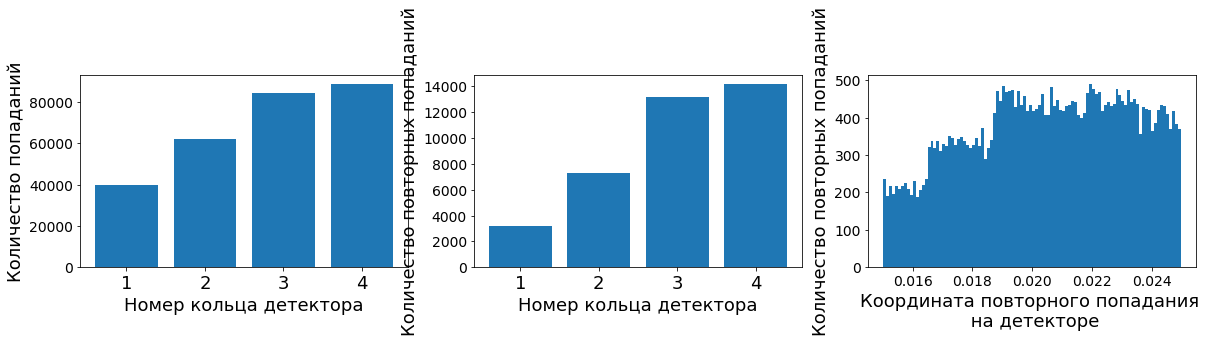

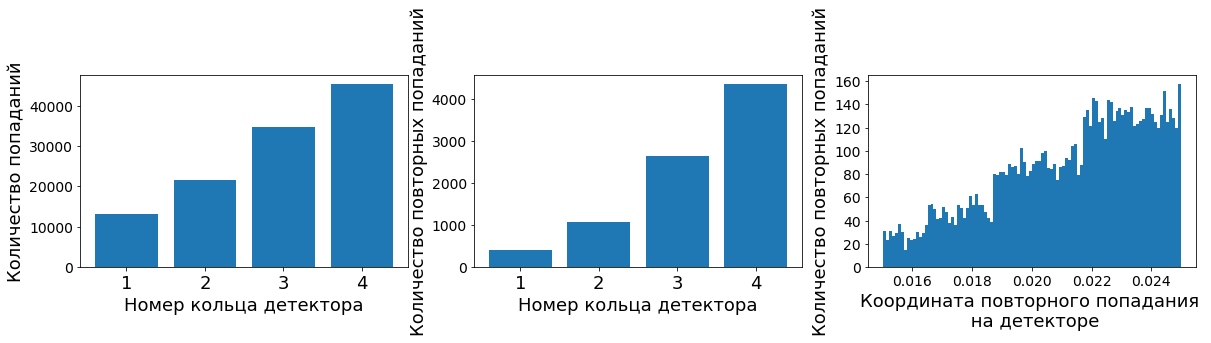

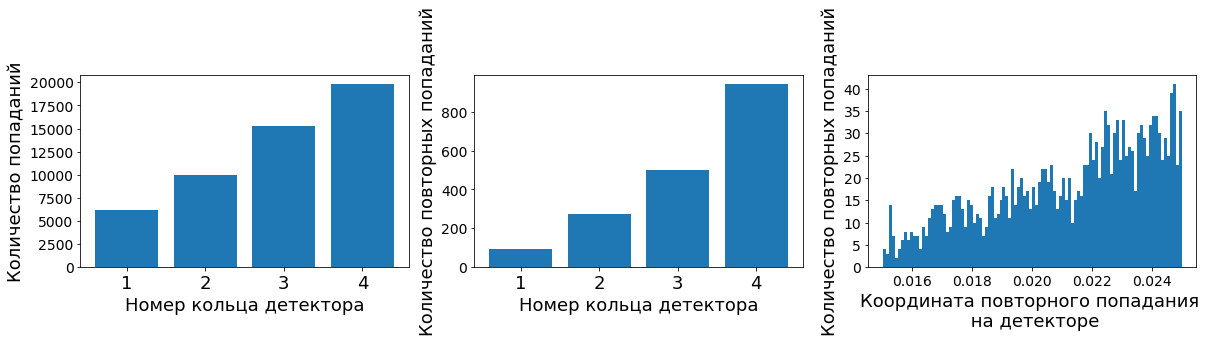

In [21]:
print("Hits in detectors: {}".format(number_of_hits))
print("More than one hit in cell: {}".format(repeated_hits))
print()
print(radii_distribution)
print()
xaxis = range(1,5)

for i in range(n_rings):
    plt.figure(figsize=(20,12))
    plt.subplot(n_rings,3,1 + i * n_rings)
    plt.bar(xaxis,radii_distribution[i])
    plt.ylabel('Количество попаданий', fontsize=18.0)
    plt.xlabel('Номер кольца детектора', fontsize=18.0)
    plt.xticks(xaxis, fontsize=18.0)
    plt.yticks(fontsize=14.0)
    
    plt.subplot(n_rings,3,2 + i * n_rings)
    plt.bar(xaxis,repeated_distribution[i])
    plt.ylabel('Количество повторных попаданий', fontsize=18.0)
    plt.xlabel('Номер кольца детектора', fontsize=18.0)
    plt.xticks(xaxis, fontsize=18.0)
    plt.yticks(fontsize=14.0)
        
    plt.subplot(n_rings,3,3 + i * n_rings)
    plt.hist(repeated_radii[i], bins=100)
    plt.ylabel('Количество повторных попаданий', fontsize=18.0)
    plt.xlabel('Координата повторного попадания \n на детекторе', fontsize=18.0)
    plt.xticks(fontsize=14.0)
    plt.yticks(fontsize=14.0)
    
    plt.show()

# Hits in detectors: [238694. 107183.  49662.]


# More than one hit in cell: 23339
# [[32832. 34641. 35390. 35468. 35049. 34500. 33719. 32640.]
#  [10887. 11783. 12531. 13759. 14785. 15956. 16906. 17992.]
#  [ 5106.  5476.  5798.  6053.  6564.  7096.  7333.  7838.]]

In [53]:
def sometest(dist):
    numerator = 4*(dist*1.7 - 0.015)
    number = np.floor(numerator/(0.01)).astype(np.int)
    return number

print(sometest(0.015))



4


In [ ]:
# with data augmentation

def random_rotation(angle, max_angle, randomizer):
    new_angle = angle + randomizer * max_angle
    if (new_angle == np.pi) or (new_angle == -np.pi):
        new_angle -= 0.00000001
    if new_angle > np.pi:
        new_angle -= 2*np.pi
    elif new_angle < -np.pi:
        new_angle += 2*np.pi
    return new_angle
    

print(len(events))
n = 0 
n_angles = 8
n_radii = 4
n_detectors = 2*n_rings
detector_width = detector_out_radius - detector_in_radius
event_data=np.zeros((n_detectors, n_angles, n_radii), dtype=np.float32)
augm_event_data=np.zeros((n_detectors, n_angles, n_radii), dtype=np.float32)
with open('data/PD_three_rings_with_particle_mass_augm_12345.dat', 'w') as outf:
    outf.write('b' + '(4x8) angles and r ' + '\n')
    for e in events:    # iterate over events
        n += 1
        all_hits = e[2]    # all hits for one event
        b = e[0]
        randomizer = 2*np.random.random_sample() - 1
        det_num = 0
        for detector in all_hits:    # iterate over detectors
            dir_num = 0
            for direction in detector:    # iterate over positive and negative direction of axis Oz
                for hit in direction:    # iterate over hits in one direction
                    p_type = hit[0]
                    particle_value = get_particle_mass(p_type)
                    h = np.asarray(hit[1])
                    if n < 3:    
                        print(p_type)
                        print(h)
                    if h.shape[0] > 0:    
                        angle = np.arctan2(h[0], h[1])
                        radius = np.sqrt(h[0] ** 2 + h[1] ** 2)
                        angle_bin = np.floor(n_angles*(angle/2/np.pi+0.5))
                        angle_bin = angle_bin.astype(np.int)
                        numerator = n_radii*(radius*detector_distances[det_num] - detector_in_radius)
                        r_bin = np.floor(numerator/(detector_width)).astype(np.int)
                        event_data[det_num * 2 + dir_num, angle_bin, r_bin] += particle_value
                         
                        # augmented data
                        augm_angle = random_rotation(angle, np.pi, randomizer)
                        augm_angle_bin = np.floor(n_angles*(augm_angle/2/np.pi+0.5))
                        augm_angle_bin = augm_angle_bin.astype(np.int)
                        augm_event_data[det_num * 2 + dir_num, augm_angle_bin, r_bin] += particle_value
                    
                if n < 3:    
                    print(' ')
                dir_num += 1
            det_num += 1
                

        outf.write(str(b) + ' ')
        
        output = np.reshape(event_data, (n_detectors, 1, -1)).astype(np.float32)        
        for j in range(output.shape[0]):    # write into file
            for i in range(output.shape[2]):
                outf.write(str(output[j][0][i]))
                outf.write(' ')
            outf.write('   ')
        outf.write('\n')
        
        outf.write(str(b) + ' ')
        # print(event_data.shape)
        augm_output = np.reshape(augm_event_data, (n_detectors, 1, -1)).astype(np.float32)
        
        for j in range(augm_output.shape[0]):
            for i in range(augm_output.shape[2]):
                outf.write(str(augm_output[j][0][i]))
                outf.write(' ')
            outf.write(' ')
        outf.write('\n')

        event_data*=0.0
        augm_event_data*=0.0